# Tech Moms Application Data
This notebook evaluates different machine learning models to predict acceptance into the Tech Moms program


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# For modeling
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, precision_recall_curve
from sklearn.pipeline import Pipeline

# ML models to benchmark
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [2]:
# For visualizations
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (14, 8)

In [3]:
# For reproducibility
np.random.seed(42)# Set random seed for reproducible results

# 1. Load and Prepare the Data

In [4]:
print("1. Loading and Preparing the Data")
print("---------------------------------")

1. Loading and Preparing the Data
---------------------------------


In [5]:
# Load the preprocessed data created in the previous notebook
# We're using the cleaned and feature-engineered data from 02_Preprocessing_and_Feature_Engineering.ipynb
df = pd.read_csv('tech_moms_preprocessed.csv')

In [6]:
print(f"Loaded dataset with {df.shape[0]} rows and {df.shape[1]} columns")
print(f"Acceptance rate: {df['accepted'].mean():.2%}")

Loaded dataset with 1732 rows and 55 columns
Acceptance rate: 32.74%


Note: The acceptance rate gives us context about class balance in our dataset. A rate far from 50% indicates class imbalance that will affect model performance and evaluation

In [7]:
# Exclude columns not needed for modeling
# We're removing identifying information and raw columns that have been transformed into engineered features
exclude_columns = ['contact_id', 'cohort', 'applicant_status',
                   'create_date', 'year', 'month', 'day', 'weekday',
                   'children', 'computer_availability', 'employment_status',
                   'salary_range', 'relationship_and_marital_status',
                   'household_income', 'education_level', 'lgbtqi_identity',
                   'veteran_status', 'race_ethnicity']

In [8]:
# Create feature matrix X and target vector y
# Separating the features from the target variable (accepted) for supervised learning
feature_columns = [col for col in df.columns if col not in exclude_columns and col != 'accepted']
X = df[feature_columns] # Features
y = df['accepted'] # Target variable

In [9]:
print(f"Number of features: {len(feature_columns)}")
print(f"X shape: {X.shape}, y shape: {y.shape}")

Number of features: 37
X shape: (1732, 37), y shape: (1732,)


Note: This gives us the dimensions of our feature matrix and target vector. It's important to verify we have the expected number of samples and features

# 2. Split the Data

In [10]:
print("\n2. Splitting the Data")
print("-------------------")


2. Splitting the Data
-------------------


In [11]:
# Split into training and testing sets (80% train, 20% test)
# We use stratified sampling to maintain the same class distribution in both sets
# This is critical since our dataset likely has class imbalance (uneven acceptance rates)
X_train, X_test, y_train, y_test = train_test_split(
                                                    X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y
                                                    )

In [12]:
print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")
print(f"Distribution of target in train: {np.bincount(y_train)}")
print(f"Distribution of target in test: {np.bincount(y_test)}")

Training set: 1385 samples
Testing set: 347 samples
Distribution of target in train: [932 453]
Distribution of target in test: [233 114]


Note: We verify that both sets have the expected number of samples and that the class distribution is preserved across training and testing sets

# 3. Function to Evaluate Models

In [13]:
print("\n3. Setting Up Model Evaluation Framework")
print("-------------------------------------")


3. Setting Up Model Evaluation Framework
-------------------------------------


In [14]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """
    Train and evaluate a model using standard classification metrics

    Parameters:
    -----------
    model : estimator object
        The machine learning model to evaluate
    X_train, X_test : DataFrames
        Training and testing feature matrices
    y_train, y_test : Series
        Training and testing target vectors
    model_name : str
        Name of the model for reporting

    Returns:
    --------
    dict
        Dictionary of evaluation metrics
    """
    # Train the model
    model.fit(X_train, y_train)
    # Fitting the model to the training data

    # Make predictions
    y_pred = model.predict(X_test)
    # Using the trained model to predict on test data

    # Get probability predictions if available
    try:
        y_proba = model.predict_proba(X_test)[:, 1]
        has_proba = True
        # Some models can provide probability estimates
        # This is useful for ROC curves and adjustable decision thresholds
    except:
        y_proba = None
        has_proba = False
        # Not all models provide probability estimates

    # Calculate metrics
    # We calculate multiple metrics because no single metric tells the whole story
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # ROC AUC if probability predictions are available
    if has_proba:
        roc_auc = roc_auc_score(y_test, y_proba)
        # Area Under the ROC Curve - measures model's ability to discriminate between classes
    else:
        roc_auc = None

    # Print results
    print(f"\nResults for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    if has_proba:
        print(f"ROC AUC: {roc_auc:.4f}")

    # Print confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    print(cm)
    # Confusion matrix shows:
    # [True Negatives, False Positives]
    # [False Negatives, True Positives]
    # This helps us understand model errors in detail

    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    # This provides detailed per-class metrics
    # Especially useful for imbalanced datasets

    # Return results dictionary
    results = {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'model': model,
        'confusion_matrix': cm,
        'y_pred': y_pred,
        'y_proba': y_proba
    }

    return results

# 4. Benchmark Different Models

In [15]:
print("\n4. Benchmarking Different Models")
print("------------------------------")



4. Benchmarking Different Models
------------------------------


In [16]:
# Create a baseline model - simple majority class classifier
from sklearn.dummy import DummyClassifier

In [17]:
# Create a dictionary of models to evaluate
models = {
    'Baseline (Majority Class)': DummyClassifier(strategy='most_frequent', random_state=42),
    # This baseline simply predicts the most common class for all samples
    # It represents the accuracy we'd get without using any features

    'Baseline (Stratified)': DummyClassifier(strategy='stratified', random_state=42),
    # This baseline makes random predictions based on the class distribution
    # It's useful to see if our models are learning patterns or just guessing

    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    # A linear model for classification - interpretable but may miss complex patterns
    # Good for understanding feature importance through coefficients

    'Random Forest': RandomForestClassifier(random_state=42),
    # Ensemble of decision trees - handles non-linear relationships well
    # Less prone to overfitting than single trees and provides feature importance

    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    # Boosting ensemble that builds trees sequentially to correct previous errors
    # Often achieves high performance but can overfit without proper tuning

    'XGBoost': XGBClassifier(random_state=42),
    # Optimized gradient boosting implementation
    # Generally provides excellent performance with built-in regularization

    'K-Nearest Neighbors': KNeighborsClassifier(),
    # Instance-based learning - makes predictions based on similar training examples
    # Simple but can be effective; sensitive to feature scaling

    'Support Vector Machine': SVC(probability=True, random_state=42),
    # Finds an optimal hyperplane to separate classes
    # Good for high-dimensional data; may be slow on large datasets

    'Naive Bayes': GaussianNB(),
    # Probabilistic classifier based on Bayes' theorem
    # Fast and simple; assumes feature independence (often violated in practice)

    'Decision Tree': DecisionTreeClassifier(random_state=42)
    # Simple tree-based model - highly interpretable but prone to overfitting
    # Serves as a building block for more complex ensemble methods
}

In [18]:
# Store results for each model
all_results = {}

In [19]:
# Evaluate each model
# We'll systematically train and evaluate all models using the same methodology
# This ensures fair comparison across different algorithms
for name, model in models.items():
    print(f"\nEvaluating {name}...")
    results = evaluate_model(model, X_train, X_test, y_train, y_test, name)
    all_results[name] = results
    # Storing results in a dictionary for later comparison and visualization


Evaluating Baseline (Majority Class)...

Results for Baseline (Majority Class):
Accuracy: 0.6715
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
ROC AUC: 0.5000

Confusion Matrix:
[[233   0]
 [114   0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80       233
           1       0.00      0.00      0.00       114

    accuracy                           0.67       347
   macro avg       0.34      0.50      0.40       347
weighted avg       0.45      0.67      0.54       347


Evaluating Baseline (Stratified)...

Results for Baseline (Stratified):
Accuracy: 0.5591
Precision: 0.3211
Recall: 0.3070
F1 Score: 0.3139
ROC AUC: 0.4947

Confusion Matrix:
[[159  74]
 [ 79  35]]

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.68      0.68       233
           1       0.32      0.31      0.31       114

    accuracy                           0.56       347
   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_


Results for Random Forest:
Accuracy: 0.5821
Precision: 0.3333
Recall: 0.2719
F1 Score: 0.2995
ROC AUC: 0.5278

Confusion Matrix:
[[171  62]
 [ 83  31]]

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.73      0.70       233
           1       0.33      0.27      0.30       114

    accuracy                           0.58       347
   macro avg       0.50      0.50      0.50       347
weighted avg       0.56      0.58      0.57       347


Evaluating Gradient Boosting...

Results for Gradient Boosting:
Accuracy: 0.6455
Precision: 0.3448
Recall: 0.0877
F1 Score: 0.1399
ROC AUC: 0.5967

Confusion Matrix:
[[214  19]
 [104  10]]

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.92      0.78       233
           1       0.34      0.09      0.14       114

    accuracy                           0.65       347
   macro avg       0.51      0.50      0.46       347
weighted a

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_

# 5. Summarize and Compare Models

In [20]:
print("\n5. Model Comparison")
print("-----------------")


5. Model Comparison
-----------------


In [21]:
# Create a DataFrame to compare model performance
# Organizing results in a DataFrame makes comparison easier and enables visualization
model_comparison = pd.DataFrame({
    'Model': [name for name in all_results.keys()],
    'Accuracy': [results['accuracy'] for results in all_results.values()],
    'Precision': [results['precision'] for results in all_results.values()],
    'Recall': [results['recall'] for results in all_results.values()],
    'F1 Score': [results['f1'] for results in all_results.values()],
    'ROC AUC': [results['roc_auc'] for results in all_results.values()]
})

In [22]:
# Sort by F1 score (descending)
# F1 score is a balanced metric for classification, especially with class imbalance
# It's the harmonic mean of precision and recall, giving a single value to optimize
model_comparison = model_comparison.sort_values('F1 Score', ascending=False)

In [23]:
print("Model performance comparison:")
print(model_comparison)

Model performance comparison:
                       Model  Accuracy  Precision    Recall  F1 Score  \
8                Naive Bayes  0.478386   0.366534  0.807018  0.504110   
1      Baseline (Stratified)  0.559078   0.321101  0.307018  0.313901   
3              Random Forest  0.582133   0.333333  0.271930  0.299517   
5                    XGBoost  0.587896   0.329412  0.245614  0.281407   
9              Decision Tree  0.561960   0.293478  0.236842  0.262136   
6        K-Nearest Neighbors  0.596542   0.303030  0.175439  0.222222   
4          Gradient Boosting  0.645533   0.344828  0.087719  0.139860   
2        Logistic Regression  0.668588   0.473684  0.078947  0.135338   
0  Baseline (Majority Class)  0.671470   0.000000  0.000000  0.000000   
7     Support Vector Machine  0.671470   0.000000  0.000000  0.000000   

    ROC AUC  
8  0.595249  
1  0.494710  
3  0.527784  
5  0.549319  
9  0.504574  
6  0.484451  
4  0.596717  
2  0.602364  
0  0.500000  
7  0.515774  


Note: This tabular view makes it easy to see which models perform best across metrics

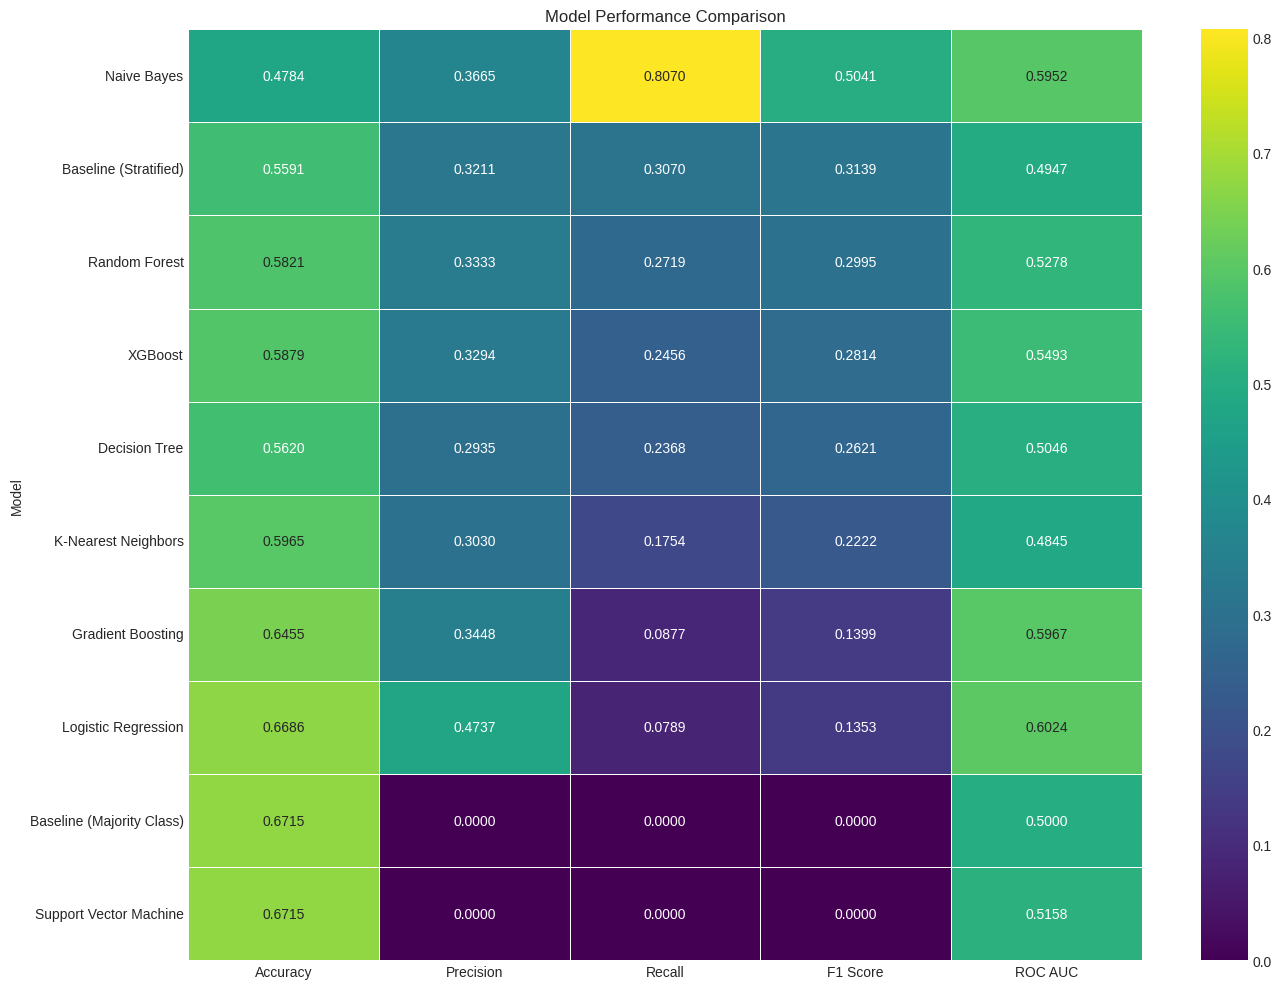

In [24]:
# Visualize model performance
plt.figure(figsize=(14, 10))

# Create a heatmap for comparison
# Heatmap visualization provides an intuitive color-coded performance comparison
# Darker colors represent better performance on each metric
sns.heatmap(
    model_comparison.set_index('Model').iloc[:, 0:5],
    annot=True,
    cmap='viridis',
    fmt='.4f',
    linewidths=.5
)
plt.title('Model Performance Comparison')
plt.tight_layout()
plt.show()

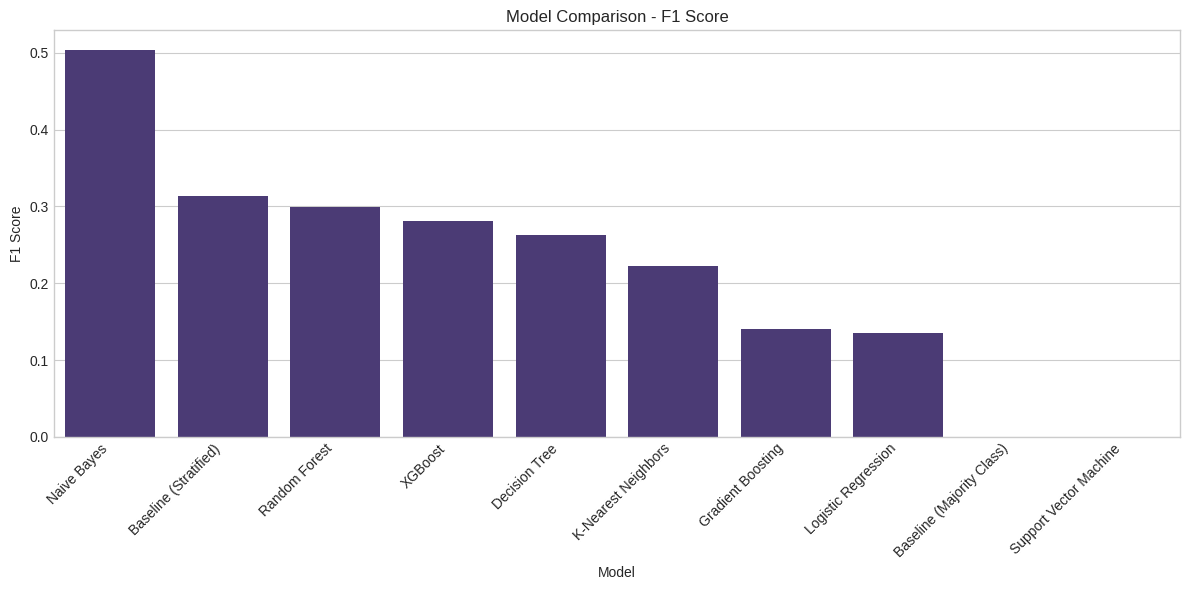

In [25]:
# Visualize F1 scores
# F1 scores are particularly important for imbalanced classification problems
# This bar chart makes it easy to compare models on this critical metric
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='F1 Score', data=model_comparison)
plt.title('Model Comparison - F1 Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 6. Feature Importance Analysis for Best Model

In [26]:
print("\n6. Feature Importance Analysis")
print("----------------------------")


6. Feature Importance Analysis
----------------------------


In [27]:
# Get best model based on F1 score
# We select the best model (excluding baselines) for feature importance analysis
best_model_name = model_comparison.iloc[0]['Model']
best_model = all_results[best_model_name]['model']
print(f"Best model: {best_model_name}")

Best model: Naive Bayes


Note: The winning model will be explored further to understand what drives its predictions

In [28]:
# Check if model has feature importance
if hasattr(best_model, 'feature_importances_'):
    # Tree-based models (Random Forest, XGBoost, etc.) have feature_importances_ attribute
    # This gives us insight into which features most influence the model's decisions

    # Get feature importances
    importances = best_model.feature_importances_

    # Create a DataFrame of feature importances
    feature_importance = pd.DataFrame({
        'Feature': feature_columns,
        'Importance': importances
    })

    # Sort by importance (descending)
    feature_importance = feature_importance.sort_values('Importance', ascending=False)

    # Display top 20 most important features
    print("\nTop 20 most important features:")
    print(feature_importance.head(20))
    # These top features are the most predictive of program acceptance
    # Understanding these can provide insights for program administrators

    # Visualize feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
    plt.title(f'Top 20 Feature Importances - {best_model_name}')
    plt.tight_layout()
    plt.show()
    # Visualization makes it easier to see relative importance among features

elif best_model_name == 'Logistic Regression':
    # Logistic Regression models use coefficients rather than feature_importances_
    # Coefficients show both magnitude AND direction of impact (positive/negative)

    # For logistic regression, use coefficients
    coefficients = best_model.coef_[0]

    # Create a DataFrame of feature coefficients
    feature_importance = pd.DataFrame({
        'Feature': feature_columns,
        'Coefficient': coefficients
    })

    # Sort by absolute value of coefficient (descending)
    feature_importance['Abs_Coefficient'] = np.abs(feature_importance['Coefficient'])
    feature_importance = feature_importance.sort_values('Abs_Coefficient', ascending=False)

    # Display top 20 features with highest coefficient magnitude
    print("\nTop 20 features by coefficient magnitude:")
    print(feature_importance[['Feature', 'Coefficient']].head(20))
    # The sign tells us whether the feature increases (+) or decreases (-) acceptance probability
    # The magnitude tells us how strongly the feature influences the prediction

    # Visualize coefficients
    plt.figure(figsize=(12, 8))
    colors = ['red' if x < 0 else 'green' for x in feature_importance.head(20)['Coefficient']]
    sns.barplot(
        x='Coefficient',
        y='Feature',
        data=feature_importance.head(20),
        palette=colors
    )
    plt.title(f'Top 20 Feature Coefficients - {best_model_name}')
    plt.axvline(x=0, color='black', linestyle='-')
    plt.tight_layout()
    plt.show()
    # This visualization shows both magnitude and direction of feature influence

else:
    print(f"\nFeature importance not available for {best_model_name}")
    # Some models don't provide built-in feature importance mechanisms
    # For these, we would need alternative methods like permutation importance


Feature importance not available for Naive Bayes


# 7. ROC Curve Comparison

In [29]:
print("\n7. ROC Curve Comparison")
print("---------------------")



7. ROC Curve Comparison
---------------------


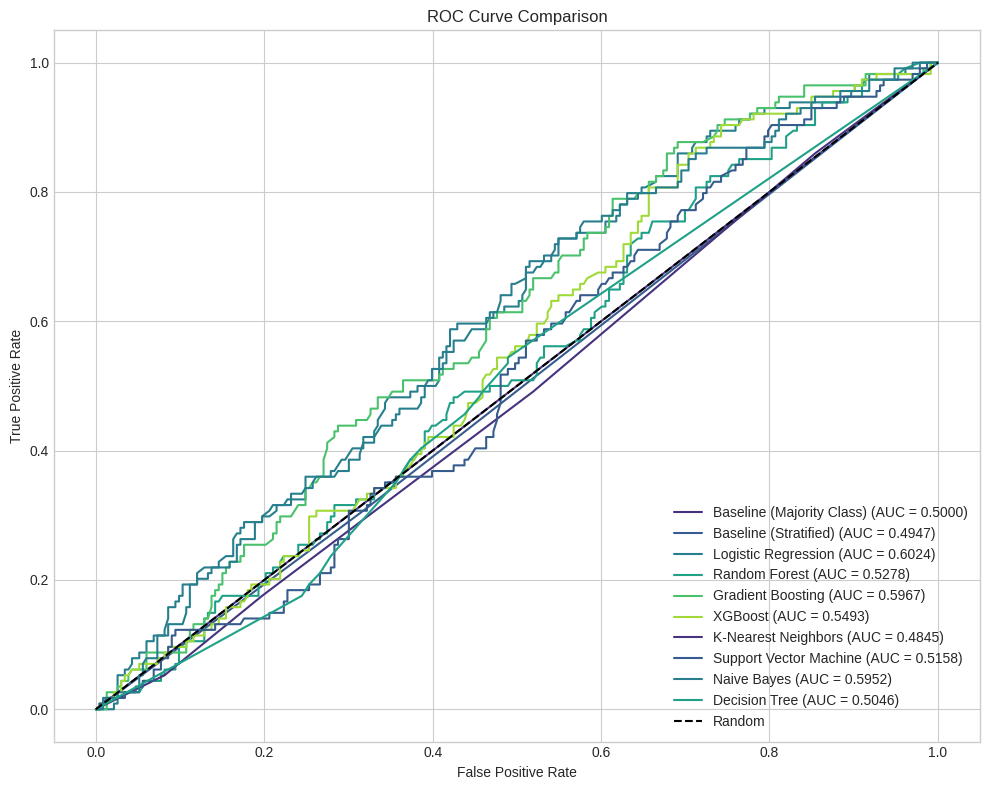

In [30]:
plt.figure(figsize=(10, 8))

# Plot ROC curve for each model
# ROC (Receiver Operating Characteristic) curves plot true positive rate vs false positive rate
# The area under the curve (AUC) quantifies overall model discrimination ability
# A perfect model has AUC=1, a random model has AUC=0.5
for name, results in all_results.items():
    if results['y_proba'] is not None:
        fpr, tpr, _ = roc_curve(y_test, results['y_proba'])
        roc_auc = results['roc_auc']
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')
        # Each model gets its own curve, allowing for visual comparison

# Plot random classifier
plt.plot([0, 1], [0, 1], 'k--', label='Random')
# The diagonal line represents a random classifier (AUC=0.5)
# Any useful model should have a curve above this line

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()
# This visualization allows us to compare all models in terms of their
# trade-off between true positive rate and false positive rate across all thresholds

In [31]:
print("Based on the benchmark results, the best performing model is:", best_model_name)
print("\nThe next steps would be:")
print("1. Hyperparameter tuning to optimize model performance")
print("2. Feature selection to focus on the most important predictors")
print("3. Threshold optimization for decision making")
print("4. More advanced evaluation like cross-validation")

print("\nThese steps will be performed in the next notebook: 04_Model_Tuning.ipynb")
print("This separation allows for clearer organization and focus on each step of the ML pipeline.")

Based on the benchmark results, the best performing model is: Naive Bayes

The next steps would be:
1. Hyperparameter tuning to optimize model performance
2. Feature selection to focus on the most important predictors
3. Threshold optimization for decision making
4. More advanced evaluation like cross-validation

These steps will be performed in the next notebook: 04_Model_Tuning.ipynb
This separation allows for clearer organization and focus on each step of the ML pipeline.


# 8. Conclusions from Benchmarking

In [33]:
print("\n8. Conclusions from Benchmarking")
print("-----------------------------")

# Summarizing the key findings and insights from our model comparison


8. Conclusions from Benchmarking
-----------------------------


In [34]:
# Compare to baseline
baseline_f1 = next((results['f1'] for name, results in all_results.items()
                   if name == 'Baseline (Majority Class)'), 0)
best_f1 = all_results[best_model_name]['f1']
improvement = (best_f1 - baseline_f1) / baseline_f1 * 100 if baseline_f1 > 0 else float('inf')

print(f"1. The best performing model was {best_model_name} with F1 score {best_f1:.4f}")
print(f"2. This represents a {improvement:.1f}% improvement over the majority class baseline")
# Quantifying improvement over baseline helps justify the model's value

1. The best performing model was Naive Bayes with F1 score 0.5041
2. This represents a inf% improvement over the majority class baseline


In [35]:
# Identify strongest and weakest models
print("3. Performance ranking from best to worst based on F1 score:")
for i, (model, f1) in enumerate(zip(model_comparison['Model'], model_comparison['F1 Score'])):
    print(f"   {i+1}. {model}: {f1:.4f}")
# This ranking shows the relative performance of all tested algorithms

3. Performance ranking from best to worst based on F1 score:
   1. Naive Bayes: 0.5041
   2. Baseline (Stratified): 0.3139
   3. Random Forest: 0.2995
   4. XGBoost: 0.2814
   5. Decision Tree: 0.2621
   6. K-Nearest Neighbors: 0.2222
   7. Gradient Boosting: 0.1399
   8. Logistic Regression: 0.1353
   9. Baseline (Majority Class): 0.0000
   10. Support Vector Machine: 0.0000


In [36]:
# Comment on feature importance
print("\n4. Feature Importance Insights:")
if 'feature_importance' in locals():
    top_features = feature_importance.head(5)
    if 'Coefficient' in top_features.columns:
        for i, (feature, coef) in enumerate(zip(top_features['Feature'], top_features['Coefficient'])):
            direction = "positively" if coef > 0 else "negatively"
            print(f"   • {feature} is {direction} associated with acceptance")
    else:
        for i, (feature, imp) in enumerate(zip(top_features['Feature'], top_features['Importance'])):
            print(f"   • {feature} is an important predictor (importance: {imp:.4f})")
# Translating technical feature importance into actionable insights


4. Feature Importance Insights:


In [37]:
# Save results for future reference
import joblib
joblib.dump(all_results, 'model_benchmark_results.pkl')
print("\nBenchmark results saved to 'model_benchmark_results.pkl' for reference in subsequent notebooks")
# Saving results ensures continuity across the notebook pipeline


Benchmark results saved to 'model_benchmark_results.pkl' for reference in subsequent notebooks


# 9. Save Best Model for Further Testing

In [38]:
print("\n9. Save Best Model for Further Testing")
print("-----------------------------------")


9. Save Best Model for Further Testing
-----------------------------------


In [39]:
# Save the best model for use in the next notebook
# Saving model objects enables continuity across notebooks in the ML pipeline
import joblib
joblib.dump(best_model, f'best_model_{best_model_name.replace(" ", "_").lower()}.pkl')
print(f"Best model saved to 'best_model_{best_model_name.replace(' ', '_').lower()}.pkl'")

Best model saved to 'best_model_naive_bayes.pkl'


In [40]:
# Also save the feature columns to ensure consistency when reloading the model
joblib.dump(feature_columns, 'model_feature_columns.pkl')
print("Feature columns saved to 'model_feature_columns.pkl'")

Feature columns saved to 'model_feature_columns.pkl'


In [42]:
# Save the performance metrics for reference
import json
# Convert numpy values to Python native types for JSON serialization
performance_metrics = {
    'accuracy': float(all_results[best_model_name]['accuracy']),
    'precision': float(all_results[best_model_name]['precision']),
    'recall': float(all_results[best_model_name]['recall']),
    'f1': float(all_results[best_model_name]['f1']),
    'roc_auc': float(all_results[best_model_name]['roc_auc']) if all_results[best_model_name]['roc_auc'] is not None else None
}
with open('best_model_metrics.json', 'w') as f:
    json.dump(performance_metrics, f, indent=4)
print("Performance metrics saved to 'best_model_metrics.json'")


Performance metrics saved to 'best_model_metrics.json'


## 10. Next Steps

In [43]:
print("\n11. Next Steps")
print("------------")

# ANALYSIS: Outline the path forward to maintain a clear ML workflow



11. Next Steps
------------


In [44]:
print("\nThis notebook has benchmarked various models and identified the best performing algorithm.")
print("The next steps in the machine learning pipeline are:")

print("\n1. Model Tuning (04_Model_Tuning.ipynb):")
print("   • Fine-tune hyperparameters of the best model")
print("   • Explore different feature combinations")
print("   • Address any class imbalance issues")
print("   • Consider ensemble methods or stacking")

print("\n2. Production Model and Insights (05_Production_Model_and_Insights.ipynb):")
print("   • Prepare the final model for deployment")
print("   • Extract actionable insights for program administrators")
print("   • Create tools for making predictions on new applicants")
print("   • Develop visualizations to communicate model findings")

print("\nThe benchmark results from this notebook will inform the model tuning process,")
print("focusing our efforts on the most promising algorithms and features.")



This notebook has benchmarked various models and identified the best performing algorithm.
The next steps in the machine learning pipeline are:

1. Model Tuning (04_Model_Tuning.ipynb):
   • Fine-tune hyperparameters of the best model
   • Explore different feature combinations
   • Address any class imbalance issues
   • Consider ensemble methods or stacking

2. Production Model and Insights (05_Production_Model_and_Insights.ipynb):
   • Prepare the final model for deployment
   • Extract actionable insights for program administrators
   • Create tools for making predictions on new applicants
   • Develop visualizations to communicate model findings

The benchmark results from this notebook will inform the model tuning process,
focusing our efforts on the most promising algorithms and features.
